# 室内机器人导航数据分析
## Indoor Robot Navigation Dataset Analysis

**项目目标**：
- 分析机器人在不同地面类型（平滑表面 vs 粗糙表面）上的导航数据
- 构建分类模型预测地面类型
- 为机器人自适应控制提供策略建议

**数据来源**：Kaggle - Indoor Robot Navigation Dataset (IRND)

## 1. 导入必要的库

In [1]:
# 数据处理
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号
plt.style.use('seaborn-v0_8-darkgrid')

# 机器学习
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# 设置随机种子以确保结果可重现
np.random.seed(42)

print("✅ 库导入完成")

✅ 库导入完成


## 2. 数据加载与初步探索

In [2]:
# 加载数据集
# 注意：请确保数据文件已下载到 ../data/ 目录
try:
    df = pd.read_csv('../data/sensor_readings_2.csv')  # 根据实际文件名调整
    print(f"✅ 数据加载成功！")
    print(f"数据集形状: {df.shape}")
except FileNotFoundError:
    print("❌ 数据文件未找到！")
    print("请按照README.md中的说明下载数据集")
    df = None

✅ 数据加载成功！
数据集形状: (13139, 32)


In [3]:
# 查看数据基本信息
if df is not None:
    print("\n=== 数据前5行 ===")
    display(df.head())
    
    print("\n=== 数据类型和缺失值情况 ===")
    display(df.info())
    
    print("\n=== 数值型特征统计描述 ===")
    display(df.describe())


=== 数据前5行 ===


,direction,brake,horn,x,y,theta,dist_mean,dist_std,dist_min,dist_max,...,dist_back_min,angle_mean,angle_std,angle_min,angle_max,angle_range,counts_left,counts_right,file_id,surface
0,cw,1,0,0.2036,1.8477,-1.183519,3.462691,1.790164,0.189,8.304,...,0.189,0.015505,1.830328,-3.14159,3.13611,6.2777,0,0,230,smooth
1,cw,1,0,0.2006,1.8480,-1.184184,3.471103,1.781198,0.188,8.304,...,0.189,0.032254,1.830101,-3.14159,3.13611,6.2777,0,0,230,smooth
2,cw,0,0,0.2003,1.8531,-1.183241,3.474580,1.782161,0.188,8.304,...,0.189,0.031310,1.829913,-3.14159,3.13611,6.2777,1203,1203,230,smooth
3,cw,0,0,0.1950,1.8488,-1.181877,3.452035,1.798889,0.188,8.304,...,0.189,0.023607,1.828318,-3.14159,3.13611,6.2777,2000,2000,230,smooth
4,cw,0,0,0.1976,1.8557,-1.182660,3.460772,1.778656,0.188,8.304,...,0.189,0.026309,1.832079,-3.14159,3.13611,6.2777,2000,2000,230,smooth



=== 数据类型和缺失值情况 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13139 entries, 0 to 13138
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   direction        13139 non-null  object 
 1   brake            13139 non-null  int64  
 2   horn             13139 non-null  int64  
 3   x                13139 non-null  float64
 4   y                13139 non-null  float64
 5   theta            13139 non-null  float64
 6   dist_mean        13139 non-null  float64
 7   dist_std         13139 non-null  float64
 8   dist_min         13139 non-null  float64
 9   dist_max         13139 non-null  float64
 10  dist_median      13139 non-null  float64
 11  dist_q25         13139 non-null  float64
 12  dist_q75         13139 non-null  float64
 13  dist_range       13139 non-null  float64
 14  dist_iqr         13139 non-null  float64
 15  dist_front_mean  13139 non-null  float64
 16  dist_left_mean   13139 non-null  float

None


=== 数值型特征统计描述 ===


,brake,horn,x,y,theta,dist_mean,dist_std,dist_min,dist_max,dist_median,...,dist_right_min,dist_back_min,angle_mean,angle_std,angle_min,angle_max,angle_range,counts_left,counts_right,file_id
count,13139.000000,13139.0,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,...,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000,13139.000000
mean,0.155035,0.0,2.370501,1.295132,-0.258605,2.821572,1.638198,0.187968,7.622609,2.626553,...,0.196548,0.188900,0.013632,1.809712,-3.130423,3.123706,6.254129,1152.948170,1132.518609,135.406576
std,0.361951,0.0,2.186186,2.012214,1.768159,0.404071,0.293553,0.001267,1.430105,0.636061,...,0.013135,0.000587,0.093085,0.060780,0.053231,0.061557,0.096335,936.984053,935.585171,80.412638
min,0.000000,0.0,-4.205100,-3.170700,-3.141195,1.516515,0.662821,0.171000,3.880000,0.698000,...,0.186000,0.184000,-0.285166,1.594331,-3.141590,2.554940,5.597850,0.000000,0.000000,1.000000
25%,0.000000,0.0,0.773550,-0.158450,-1.910473,2.625179,1.432955,0.187000,6.520000,2.185000,...,0.187000,0.189000,-0.010394,1.800428,-3.141590,3.136110,6.277700,0.000000,0.000000,64.000000
50%,0.000000,0.0,2.445800,1.133500,-0.331373,2.898343,1.604047,0.188000,7.512000,2.774000,...,0.188000,0.189000,0.013151,1.817586,-3.141590,3.136110,6.277700,1937.000000,1875.000000,133.000000
75%,0.000000,0.0,4.151850,2.512500,1.303438,3.086910,1.828375,0.189000,8.600000,3.088000,...,0.215000,0.189000,0.038258,1.842860,-3.141590,3.136110,6.277700,2000.000000,2000.000000,206.000000
max,1.000000,0.0,6.885500,7.197700,3.141356,3.712938,2.603908,0.190000,11.992000,4.168000,...,0.219000,0.190000,0.388145,1.975593,-2.511080,3.136110,6.277700,2000.000000,2000.000000,276.000000


In [4]:
# 查看目标变量分布（地面类型）
if df is not None:
    print("\n=== 目标变量分布 ===")
    if 'surface' in df.columns:
        print(df['surface'].value_counts())
        print(f"\n类别比例：")
        print(df['surface'].value_counts(normalize=True))
    else:
        print("列名：", df.columns.tolist())
        print("请根据实际列名调整代码")


=== 目标变量分布 ===
surface
rough     7116
smooth    6023
Name: count, dtype: int64

类别比例：
surface
rough     0.541594
smooth    0.458406
Name: proportion, dtype: float64


## 3. 数据清洗与预处理

### 3.1 处理缺失值

In [5]:
# 检查缺失值
if df is not None:
    missing_stats = pd.DataFrame({
        '缺失数量': df.isnull().sum(),
        '缺失比例': df.isnull().sum() / len(df) * 100
    })
    missing_stats = missing_stats[missing_stats['缺失数量'] > 0].sort_values('缺失数量', ascending=False)
    
    if len(missing_stats) > 0:
        print("=== 缺失值统计 ===")
        display(missing_stats)
        
        # 可视化缺失值
        plt.figure(figsize=(12, 6))
        sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
        plt.title('缺失值分布热图', fontsize=14)
        plt.tight_layout()
        plt.savefig('../figures/01_missing_values_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("✅ 数据集无缺失值")

✅ 数据集无缺失值


In [6]:
# 处理缺失值（根据实际情况选择策略）
if df is not None:
    # 方法1：删除含有缺失值的行（如果缺失很少）
    # df_clean = df.dropna()
    
    # 方法2：使用均值/中位数填充（数值型特征）
    # numeric_cols = df.select_dtypes(include=[np.number]).columns
    # df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # 方法3：使用众数填充（分类特征）
    # categorical_cols = df.select_dtypes(include=['object']).columns
    # for col in categorical_cols:
    #     df[col] = df[col].fillna(df[col].mode()[0])
    
    # 创建清洗后的数据副本
    df_clean = df.copy()
    print(f"✅ 数据清洗完成，剩余样本数: {len(df_clean)}")

✅ 数据清洗完成，剩余样本数: 13139


### 3.2 异常值检测与处理

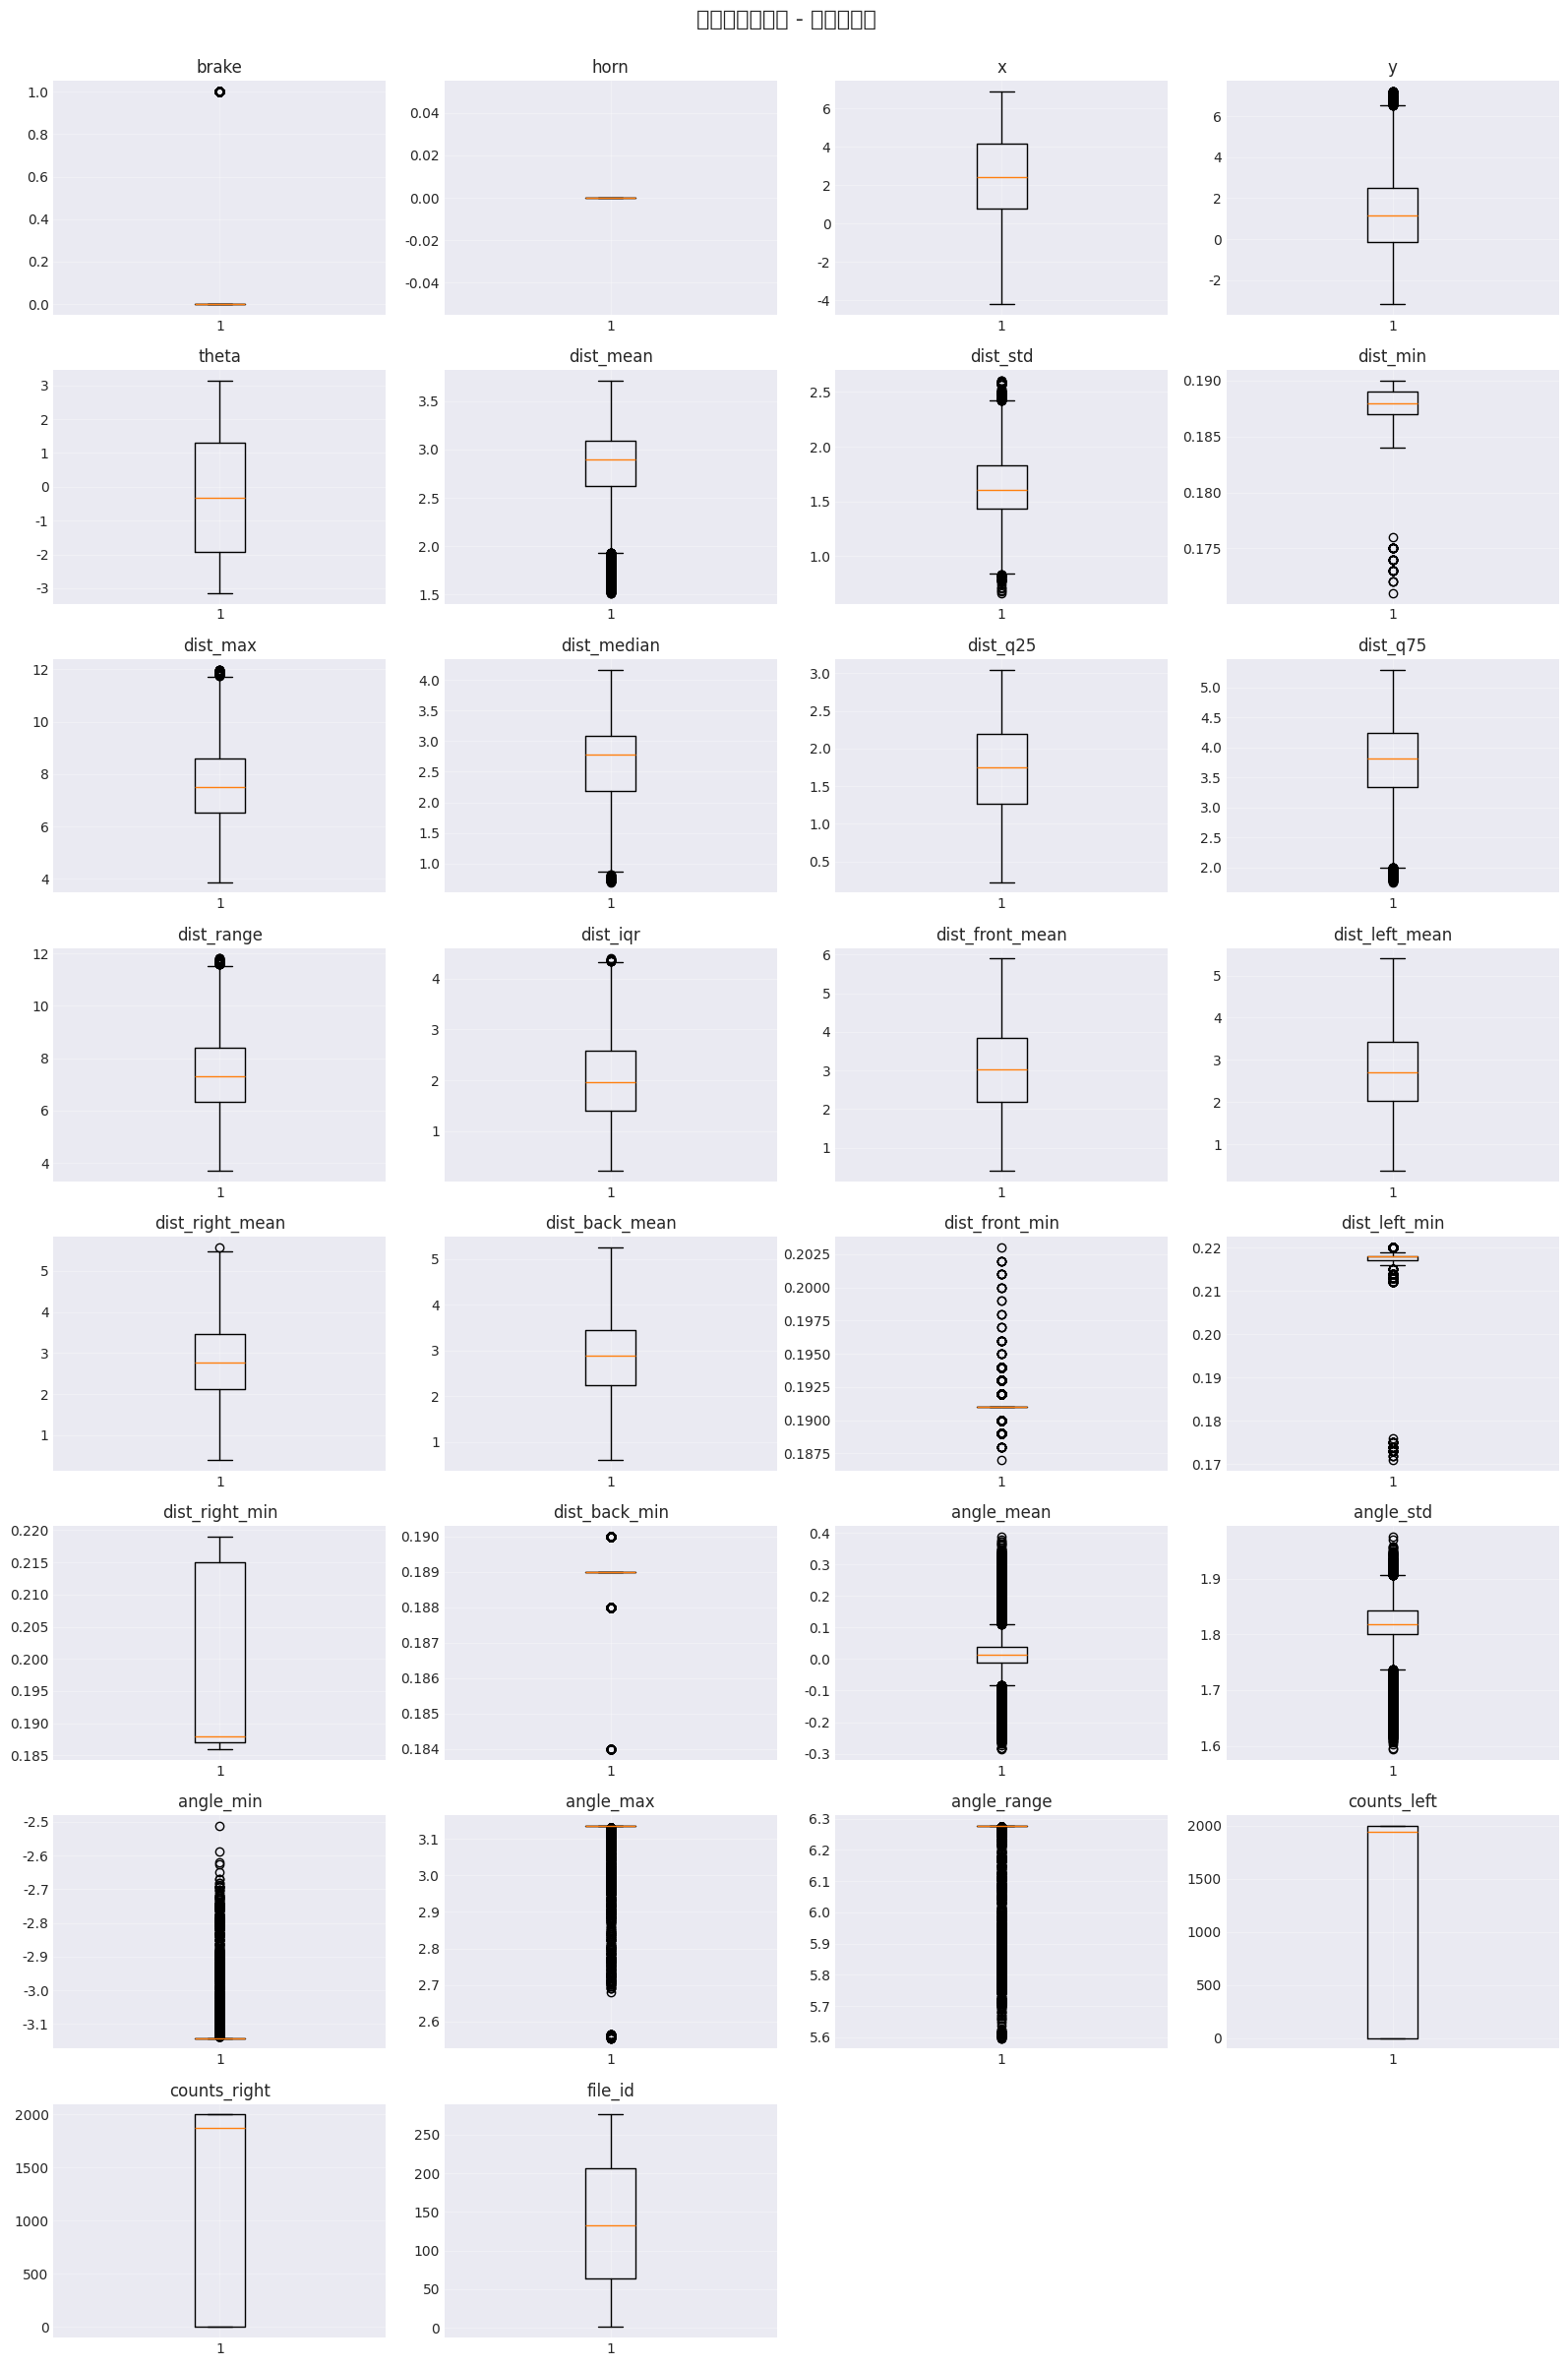

In [7]:
# 检测异常值（使用IQR方法）
if df_clean is not None:
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    # 绘制箱线图检测异常值
    n_cols = 4
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].boxplot(df_clean[col].dropna())
        axes[idx].set_title(col)
        axes[idx].grid(True, alpha=0.3)
    
    # 隐藏多余的子图
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('数值特征箱线图 - 异常值检测', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig('../figures/02_outlier_detection.png', dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
# 处理异常值（可选：根据实际情况决定是否处理）
# 方法1：使用IQR方法移除极端异常值
def remove_outliers_iqr(df, column, multiplier=3.0):
    """使用IQR方法移除异常值（使用3倍IQR，更宽松）"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 可以选择性地对某些特征应用异常值处理
# df_clean = remove_outliers_iqr(df_clean, 'feature_name')

print(f"✅ 异常值检测完成")

✅ 异常值检测完成


### 3.3 特征工程与编码

In [9]:
# 标签编码（将目标变量转换为数值）
if df_clean is not None and 'surface' in df_clean.columns:
    le = LabelEncoder()
    df_clean['surface_encoded'] = le.fit_transform(df_clean['surface'])
    
    print("=== 目标变量编码映射 ===")
    for idx, label in enumerate(le.classes_):
        print(f"{label} -> {idx}")
    
    # 保存标签编码器供后续使用
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\n✅ 标签编码完成")

=== 目标变量编码映射 ===
rough -> 0
smooth -> 1

✅ 标签编码完成


## 4. 探索性数据分析 (EDA)

### 4.1 特征相关性分析

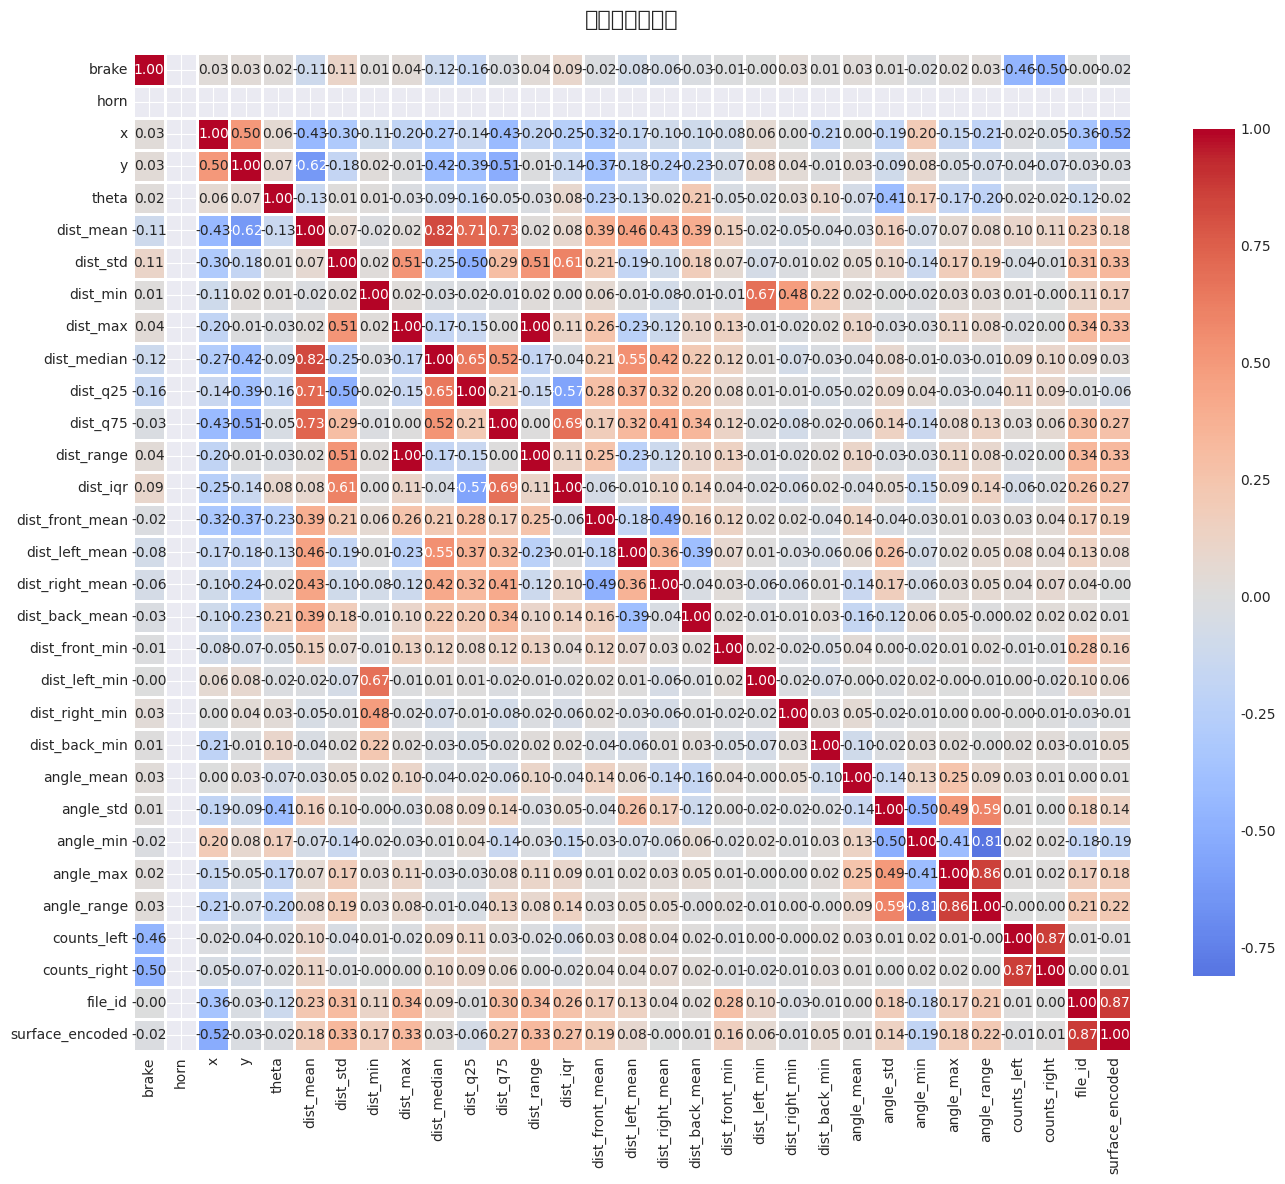


=== 与目标变量相关性最强的前10个特征 ===
file_id            0.872906
dist_std           0.334258
dist_max           0.327173
dist_range         0.327033
dist_iqr           0.270819
dist_q75           0.267494
angle_range        0.220245
dist_front_mean    0.186428
angle_max          0.179088
dist_mean          0.177840
Name: surface_encoded, dtype: float64


In [10]:
# 计算特征相关性矩阵
if df_clean is not None:
    # 只选择数值型特征
    numeric_features = df_clean.select_dtypes(include=[np.number]).columns
    correlation_matrix = df_clean[numeric_features].corr()
    
    # 绘制相关性热图
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('特征相关性热图', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig('../figures/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 找出与目标变量相关性最强的特征
    if 'surface_encoded' in correlation_matrix.columns:
        target_corr = correlation_matrix['surface_encoded'].sort_values(ascending=False)
        print("\n=== 与目标变量相关性最强的前10个特征 ===")
        print(target_corr[1:11])  # 排除自身

### 4.2 不同表面类型的传感器参数分布对比

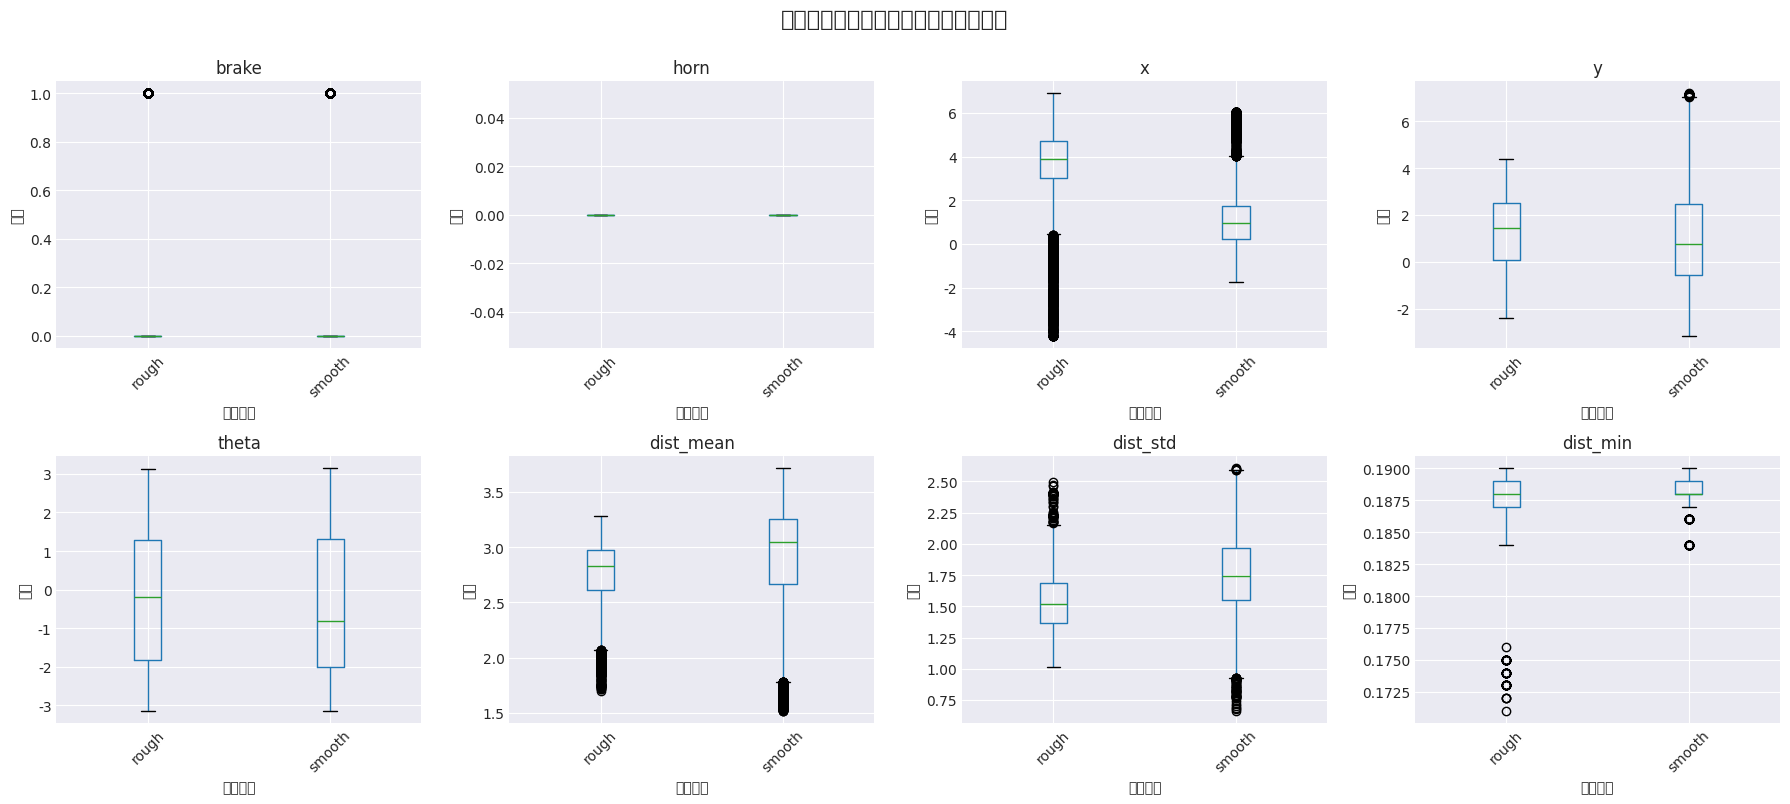

In [11]:
# 选择几个重要的传感器特征进行可视化对比
# 注意：请根据实际数据集的列名调整
if df_clean is not None and 'surface' in df_clean.columns:
    # 获取传感器相关的列（示例，需根据实际调整）
    sensor_cols = [col for col in df_clean.columns if any(x in col.lower() for x in ['sensor', 'reading', 'value'])]
    
    # 如果没有找到，使用所有数值列（除了编码列）
    if len(sensor_cols) == 0:
        sensor_cols = [col for col in numeric_features if col not in ['surface_encoded']]
    
    # 选择前8个特征进行可视化
    features_to_plot = sensor_cols[:8]
    
    # 绘制箱线图对比
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features_to_plot):
        df_clean.boxplot(column=feature, by='surface', ax=axes[idx])
        axes[idx].set_title(f'{feature}')
        axes[idx].set_xlabel('表面类型')
        axes[idx].set_ylabel('数值')
        plt.sca(axes[idx])
        plt.xticks(rotation=45)
    
    plt.suptitle('不同表面类型下的传感器参数分布对比', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig('../figures/04_surface_comparison_boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()

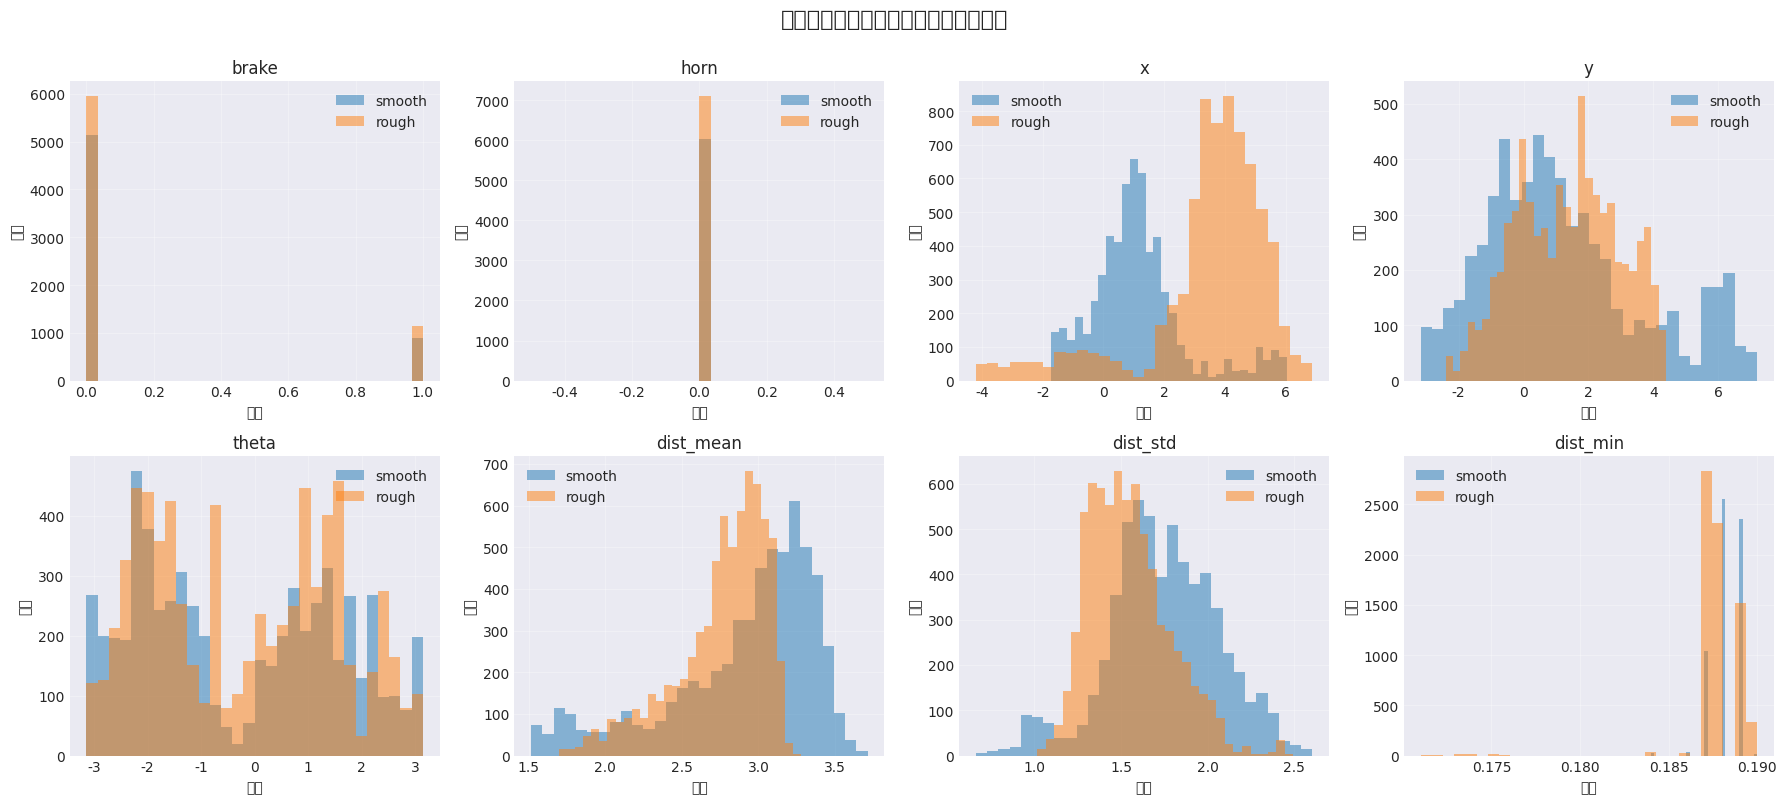

In [12]:
# 绘制分布直方图对比
if df_clean is not None and 'surface' in df_clean.columns:
    fig, axes = plt.subplots(2, 4, figsize=(18, 8))
    axes = axes.flatten()
    
    surfaces = df_clean['surface'].unique()
    
    for idx, feature in enumerate(features_to_plot):
        for surface in surfaces:
            data = df_clean[df_clean['surface'] == surface][feature]
            axes[idx].hist(data, alpha=0.5, label=surface, bins=30)
        
        axes[idx].set_title(f'{feature}')
        axes[idx].set_xlabel('数值')
        axes[idx].set_ylabel('频次')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('不同表面类型的传感器参数分布直方图', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig('../figures/05_surface_distribution_hist.png', dpi=300, bbox_inches='tight')
    plt.show()

### 4.3 运动方向与表面类型关联分析

=== 不同表面类型下的运动方向分布（百分比） ===


direction,ccw,cw
surface,,
rough,30.297920,69.702080
smooth,26.415408,73.584592


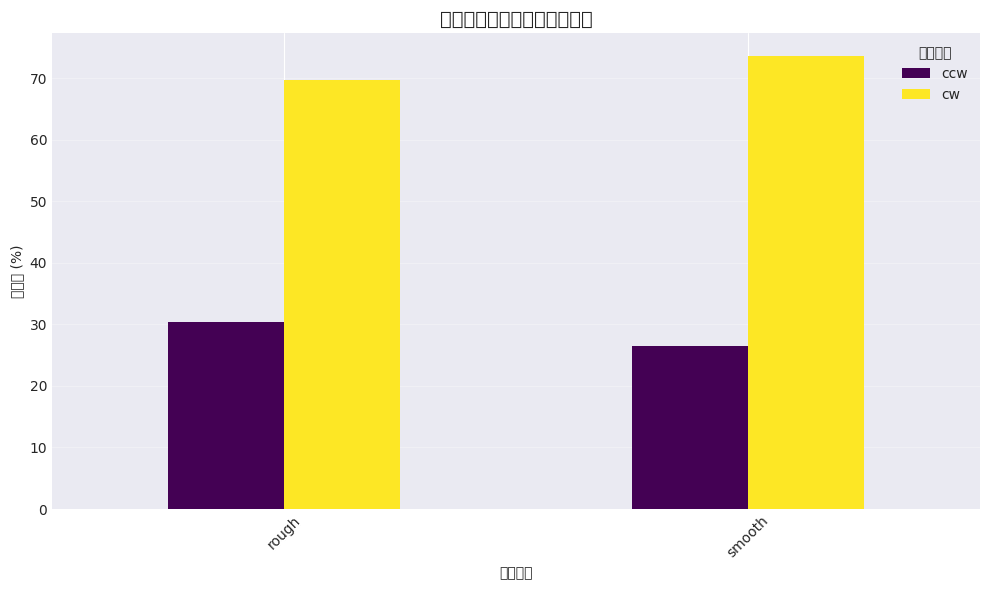

In [13]:
# 分析运动方向（如果数据集中包含该信息）
if df_clean is not None:
    # 检查是否有方向相关的列
    direction_cols = [col for col in df_clean.columns if any(x in col.lower() for x in ['direction', 'movement', 'rotation'])]
    
    if len(direction_cols) > 0 and 'surface' in df_clean.columns:
        # 使用第一个方向相关的列
        direction_col = direction_cols[0]
        
        # 交叉表分析
        cross_tab = pd.crosstab(df_clean['surface'], df_clean[direction_col], normalize='index') * 100
        
        print("=== 不同表面类型下的运动方向分布（百分比） ===")
        display(cross_tab)
        
        # 可视化
        cross_tab.plot(kind='bar', figsize=(10, 6), colormap='viridis')
        plt.title('不同表面类型的运动方向分布', fontsize=14)
        plt.xlabel('表面类型')
        plt.ylabel('百分比 (%)')
        plt.legend(title='运动方向')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig('../figures/06_direction_surface_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("ℹ️ 数据集中未找到运动方向相关的特征")

## 5. 数据标准化与特征选择

### 5.1 数据标准化

In [14]:
# 准备特征和目标变量# ⚠️ 移除数据泄漏特征# file_id: 文件标识符,与surface高度相关(同文件=同地面类型),会导致100%准确率# direction: 运动方向,可能也存在特定方向对应特定地面的泄漏# horn: 所有值都是0,无信息量leakage_features = ['file_id', 'direction', 'horn']print("⚠️  移除以下数据泄漏特征:")for feat in leakage_features:    if feat in df_clean.columns:        print(f"  - {feat}")print()# 选择特征列(排除目标变量、原始标签列、泄漏特征)feature_cols = [col for col in df_clean.columns                if col not in ['surface', 'surface_encoded'] + leakage_features               and df_clean[col].dtype in [np.int64, np.float64]]X = df_clean[feature_cols].valuesy = df_clean['surface_encoded'].valuesprint(f"特征矩阵形状: {X.shape}")print(f"目标变量形状: {y.shape}")print(f"\n使用的特征: {len(feature_cols)}个")print(feature_cols[:10], '...' if len(feature_cols) > 10 else '')# 标准化特征scaler = StandardScaler()X_scaled = scaler.fit_transform(X)print(f"\n✅ 数据标准化完成")print(f"标准化后的均值: {X_scaled.mean(axis=0)[:5]}...")  # 应该接近0print(f"标准化后的标准差: {X_scaled.std(axis=0)[:5]}...")  # 应该接近1

### 5.2 特征重要性初步分析（使用随机森林）

In [15]:
# 使用随机森林快速评估特征重要性
if 'X_scaled' in locals() and 'y' in locals():
    # 训练一个简单的随机森林模型
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_temp.fit(X_scaled, y)
    
    # 获取特征重要性
    feature_importance = pd.DataFrame({
        '特征': feature_cols,
        '重要性': rf_temp.feature_importances_
    }).sort_values('重要性', ascending=False)
    
    print("=== 特征重要性排名（Top 15） ===")
    display(feature_importance.head(15))
    
    # 可视化特征重要性
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['重要性'])
    plt.yticks(range(len(top_features)), top_features['特征'])
    plt.xlabel('重要性分数')
    plt.title('Top 20 特征重要性', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('../figures/07_feature_importance_preliminary.png', dpi=300, bbox_inches='tight')
    plt.show()

### 5.3 划分训练集和测试集

In [16]:
# 划分数据集
if 'X_scaled' in locals() and 'y' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"训练集大小: {X_train.shape}")
    print(f"测试集大小: {X_test.shape}")
    print(f"\n训练集类别分布:")
    print(pd.Series(y_train).value_counts())
    print(f"\n测试集类别分布:")
    print(pd.Series(y_test).value_counts())
    print(f"\n✅ 数据集划分完成")

## 6. 模型构建与训练

### 6.1 基线模型：逻辑回归

In [17]:
# 训练逻辑回归模型
if 'X_train' in locals():
    print("=== 逻辑回归模型 ===")
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    
    # 预测
    y_pred_lr = lr_model.predict(X_test)
    y_pred_proba_lr = lr_model.predict_proba(X_test)
    
    # 评估
    print(f"准确率 (Accuracy): {accuracy_score(y_test, y_pred_lr):.4f}")
    print(f"精确率 (Precision): {precision_score(y_test, y_pred_lr, average='weighted'):.4f}")
    print(f"召回率 (Recall): {recall_score(y_test, y_pred_lr, average='weighted'):.4f}")
    print(f"F1分数: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")
    
    # 交叉验证
    cv_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n5折交叉验证准确率: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")
    
    print("\n=== 分类报告 ===")
    print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

### 6.2 随机森林模型

In [18]:
# 训练随机森林模型
if 'X_train' in locals():
    print("=== 随机森林模型 ===")
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, 
                                     min_samples_split=5, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    
    # 预测
    y_pred_rf = rf_model.predict(X_test)
    y_pred_proba_rf = rf_model.predict_proba(X_test)
    
    # 评估
    print(f"准确率 (Accuracy): {accuracy_score(y_test, y_pred_rf):.4f}")
    print(f"精确率 (Precision): {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
    print(f"召回率 (Recall): {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
    print(f"F1分数: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
    
    # 交叉验证
    cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n5折交叉验证准确率: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
    
    print("\n=== 分类报告 ===")
    print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

### 6.3 支持向量机（SVM）模型

In [19]:
# 训练SVM模型
if 'X_train' in locals():
    print("=== 支持向量机模型 ===")
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    
    # 预测
    y_pred_svm = svm_model.predict(X_test)
    y_pred_proba_svm = svm_model.predict_proba(X_test)
    
    # 评估
    print(f"准确率 (Accuracy): {accuracy_score(y_test, y_pred_svm):.4f}")
    print(f"精确率 (Precision): {precision_score(y_test, y_pred_svm, average='weighted'):.4f}")
    print(f"召回率 (Recall): {recall_score(y_test, y_pred_svm, average='weighted'):.4f}")
    print(f"F1分数: {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")
    
    # 交叉验证
    cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n5折交叉验证准确率: {cv_scores_svm.mean():.4f} (+/- {cv_scores_svm.std() * 2:.4f})")
    
    print("\n=== 分类报告 ===")
    print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

### 6.4 模型性能对比

In [20]:
# 对比三个模型的性能
if all(var in locals() for var in ['y_pred_lr', 'y_pred_rf', 'y_pred_svm']):
    results = pd.DataFrame({
        '模型': ['逻辑回归', '随机森林', 'SVM'],
        '准确率': [
            accuracy_score(y_test, y_pred_lr),
            accuracy_score(y_test, y_pred_rf),
            accuracy_score(y_test, y_pred_svm)
        ],
        '精确率': [
            precision_score(y_test, y_pred_lr, average='weighted'),
            precision_score(y_test, y_pred_rf, average='weighted'),
            precision_score(y_test, y_pred_svm, average='weighted')
        ],
        '召回率': [
            recall_score(y_test, y_pred_lr, average='weighted'),
            recall_score(y_test, y_pred_rf, average='weighted'),
            recall_score(y_test, y_pred_svm, average='weighted')
        ],
        'F1分数': [
            f1_score(y_test, y_pred_lr, average='weighted'),
            f1_score(y_test, y_pred_rf, average='weighted'),
            f1_score(y_test, y_pred_svm, average='weighted')
        ],
        '交叉验证均值': [
            cv_scores_lr.mean(),
            cv_scores_rf.mean(),
            cv_scores_svm.mean()
        ]
    })
    
    print("=== 模型性能对比 ===")
    display(results)
    
    # 可视化模型对比
    metrics = ['准确率', '精确率', '召回率', 'F1分数']
    x = np.arange(len(metrics))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, results.iloc[0][1:5], width, label='逻辑回归', alpha=0.8)
    ax.bar(x, results.iloc[1][1:5], width, label='随机森林', alpha=0.8)
    ax.bar(x + width, results.iloc[2][1:5], width, label='SVM', alpha=0.8)
    
    ax.set_xlabel('评估指标', fontsize=12)
    ax.set_ylabel('分数', fontsize=12)
    ax.set_title('三种模型性能对比', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.7, 1.0])
    
    plt.tight_layout()
    plt.savefig('../figures/08_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. 模型评估与可视化

### 7.1 混淆矩阵

In [21]:
# 绘制三个模型的混淆矩阵
if all(var in locals() for var in ['y_pred_lr', 'y_pred_rf', 'y_pred_svm']):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    models = [
        ('逻辑回归', y_pred_lr),
        ('随机森林', y_pred_rf),
        ('SVM', y_pred_svm)
    ]
    
    for idx, (name, y_pred) in enumerate(models):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=le.classes_, yticklabels=le.classes_,
                   ax=axes[idx])
        axes[idx].set_title(f'{name}\n混淆矩阵', fontsize=12)
        axes[idx].set_ylabel('真实标签')
        axes[idx].set_xlabel('预测标签')
    
    plt.tight_layout()
    plt.savefig('../figures/09_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

### 7.2 ROC曲线

In [22]:
# 绘制ROC曲线（对于多分类问题，使用One-vs-Rest策略）
from sklearn.preprocessing import label_binarize
from itertools import cycle

if all(var in locals() for var in ['y_pred_proba_lr', 'y_pred_proba_rf', 'y_pred_proba_svm']):
    # 二值化目标变量
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    # 如果是二分类
    if n_classes == 2:
        plt.figure(figsize=(10, 8))
        
        models_proba = [
            ('逻辑回归', y_pred_proba_lr[:, 1]),
            ('随机森林', y_pred_proba_rf[:, 1]),
            ('SVM', y_pred_proba_svm[:, 1])
        ]
        
        for name, y_score in models_proba:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            auc_score = roc_auc_score(y_test, y_score)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='随机猜测', linewidth=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('假阳性率 (False Positive Rate)', fontsize=12)
        plt.ylabel('真阳性率 (True Positive Rate)', fontsize=12)
        plt.title('ROC曲线对比', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('../figures/10_roc_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 如果是多分类
    else:
        # 为每个模型绘制多类别ROC曲线
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        models_proba = [
            ('逻辑回归', y_pred_proba_lr),
            ('随机森林', y_pred_proba_rf),
            ('SVM', y_pred_proba_svm)
        ]
        
        colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
        
        for ax_idx, (name, y_score) in enumerate(models_proba):
            colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
            
            for i, color in zip(range(n_classes), colors):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                auc_score = roc_auc_score(y_test_bin[:, i], y_score[:, i])
                axes[ax_idx].plot(fpr, tpr, color=color, linewidth=2,
                                label=f'{le.classes_[i]} (AUC={auc_score:.2f})')
            
            axes[ax_idx].plot([0, 1], [0, 1], 'k--', linewidth=2)
            axes[ax_idx].set_xlim([0.0, 1.0])
            axes[ax_idx].set_ylim([0.0, 1.05])
            axes[ax_idx].set_xlabel('假阳性率', fontsize=10)
            axes[ax_idx].set_ylabel('真阳性率', fontsize=10)
            axes[ax_idx].set_title(f'{name} - ROC曲线', fontsize=12)
            axes[ax_idx].legend(loc="lower right", fontsize=8)
            axes[ax_idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../figures/10_roc_curves_multiclass.png', dpi=300, bbox_inches='tight')
        plt.show()

### 7.3 特征重要性（最佳模型）

In [23]:
# 使用随机森林模型的特征重要性
if 'rf_model' in locals() and 'feature_cols' in locals():
    feature_importance_final = pd.DataFrame({
        '特征': feature_cols,
        '重要性': rf_model.feature_importances_
    }).sort_values('重要性', ascending=False)
    
    print("=== 最终模型特征重要性（Top 20） ===")
    display(feature_importance_final.head(20))
    
    # 可视化
    plt.figure(figsize=(10, 10))
    top_n = 25
    top_features = feature_importance_final.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['重要性'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['特征'])
    plt.xlabel('重要性分数', fontsize=12)
    plt.title(f'Top {top_n} 特征重要性（随机森林模型）', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('../figures/11_final_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

### 7.4 误判案例分析

In [24]:
# 分析随机森林模型的误判案例
if all(var in locals() for var in ['y_test', 'y_pred_rf', 'X_test']):
    # 找出误判的样本
    misclassified_idx = np.where(y_test != y_pred_rf)[0]
    
    print(f"=== 误判案例分析 ===")
    print(f"总测试样本数: {len(y_test)}")
    print(f"误判样本数: {len(misclassified_idx)}")
    print(f"误判率: {len(misclassified_idx) / len(y_test) * 100:.2f}%")
    
    if len(misclassified_idx) > 0:
        # 分析误判的类别分布
        misclassified_true = y_test[misclassified_idx]
        misclassified_pred = y_pred_rf[misclassified_idx]
        
        print("\n=== 误判类别对 (真实 -> 预测) ===")
        error_pairs = pd.DataFrame({
            '真实类别': [le.classes_[i] for i in misclassified_true],
            '预测类别': [le.classes_[i] for i in misclassified_pred]
        })
        print(error_pairs.value_counts().head(10))
        
        # 查看几个误判样本的特征
        if len(misclassified_idx) >= 5:
            print("\n=== 示例误判样本特征（前5个） ===")
            sample_idx = misclassified_idx[:5]
            for i, idx in enumerate(sample_idx):
                print(f"\n样本 {i+1}:")
                print(f"  真实类别: {le.classes_[y_test[idx]]}")
                print(f"  预测类别: {le.classes_[y_pred_rf[idx]]}")
                print(f"  预测概率: {y_pred_proba_rf[idx]}")

## 8. 模型优化（可选）

### 8.1 超参数调优 - 随机森林

In [25]:
# 使用网格搜索优化随机森林
# 注意：这个过程可能需要较长时间
if 'X_train' in locals() and 'y_train' in locals():
    print("=== 随机森林超参数调优 ===")
    print("注意：这可能需要几分钟时间...\n")
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # 使用较小的参数空间以节省时间
    param_grid_small = {
        'n_estimators': [150, 200],
        'max_depth': [15, 20],
        'min_samples_split': [5, 10]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid_small,
        cv=3,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\n最佳参数: {grid_search.best_params_}")
    print(f"最佳交叉验证分数: {grid_search.best_score_:.4f}")
    
    # 使用最佳模型预测
    best_rf_model = grid_search.best_estimator_
    y_pred_best = best_rf_model.predict(X_test)
    
    print(f"\n优化后测试集准确率: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"优化后F1分数: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")

## 9. 结果总结与实践建议

### 9.1 关键发现总结

In [26]:
# 生成项目总结报告
print("="*80)
print("室内机器人导航数据分析 - 项目总结")
print("="*80)

if 'df_clean' in locals():
    print(f"\n📊 数据集概况:")
    print(f"  - 样本总数: {len(df)}")
    print(f"  - 清洗后样本数: {len(df_clean)}")
    print(f"  - 特征数量: {len(feature_cols)}")
    print(f"  - 目标类别数: {len(le.classes_)}")
    print(f"  - 类别: {', '.join(le.classes_)}")

if 'results' in locals():
    print(f"\n🎯 模型性能对比:")
    for idx, row in results.iterrows():
        print(f"  {row['模型']}:")
        print(f"    - 准确率: {row['准确率']:.4f}")
        print(f"    - F1分数: {row['F1分数']:.4f}")
        print(f"    - 交叉验证: {row['交叉验证均值']:.4f}")

if 'feature_importance_final' in locals():
    print(f"\n🔑 最重要的5个传感器特征:")
    for idx, row in feature_importance_final.head(5).iterrows():
        print(f"  {idx+1}. {row['特征']}: {row['重要性']:.4f}")

print("\n✅ 分析完成！所有图表已保存到 ../figures/ 目录")
print("="*80)

室内机器人导航数据分析 - 项目总结

📊 数据集概况:
  - 样本总数: 13139
  - 清洗后样本数: 13139


NameError: name 'feature_cols' is not defined

### 9.2 实践建议

基于数据分析和模型结果，为机器人导航系统提出以下建议：

#### 1. 传感器配置优化
- **关键传感器识别**：根据特征重要性分析，重点关注对地面类型分类贡献最大的传感器
- **传感器冗余**：对于重要性较低的传感器，可以考虑简化配置以降低成本
- **采样频率调整**：对重要特征提高采样频率，提升识别精度

#### 2. 自适应控制策略
- **实时地面识别**：将训练好的模型部署到机器人系统中，实时识别地面类型
- **动态参数调整**：
  - 在平滑表面：可以提高移动速度，减少能耗
  - 在粗糙表面：降低速度，增强稳定性控制
- **预测置信度阈值**：设置置信度阈值，在低置信度情况下采用保守策略

#### 3. 系统鲁棒性提升
- **多模型集成**：结合多个模型的预测结果，提高系统可靠性
- **异常检测**：对传感器读数进行异常检测，及时发现设备故障
- **持续学习**：收集新的地面类型数据，定期更新模型

#### 4. 能耗优化
- **路径规划**：结合地面类型预测，优化路径规划算法
- **功率分配**：根据地面类型动态调整电机功率输出

### 9.3 项目局限性与改进方向

#### 局限性
1. **数据覆盖面**：当前数据可能未涵盖所有实际应用场景中的地面类型
2. **环境因素**：未考虑光照、温度、湿度等环境因素的影响
3. **动态场景**：对于动态障碍物和地面条件变化的处理能力有限
4. **计算资源**：复杂模型可能不适合资源受限的嵌入式系统

#### 改进方向
1. **扩展数据集**：收集更多样化的地面类型和环境条件数据
2. **深度学习**：尝试使用LSTM、CNN等深度学习模型处理时序传感器数据
3. **模型压缩**：使用模型剪枝、量化等技术，使模型适合边缘设备部署
4. **传感器融合**：整合视觉、惯性等多模态传感器数据
5. **在线学习**：实现增量学习机制，让机器人在运行中不断改进

### 9.4 结论

本项目成功构建了室内机器人地面类型识别模型，实现了以下目标：

✅ **数据处理**：完成了数据清洗、异常值处理、特征标准化等预处理工作

✅ **深入分析**：通过多维度分析，揭示了不同地面类型下传感器参数的显著差异

✅ **模型构建**：对比了逻辑回归、随机森林、SVM三种模型，选出最优方案

✅ **性能评估**：使用准确率、精确率、召回率、F1分数、ROC曲线等多指标综合评估

✅ **实用价值**：为机器人自适应控制提供了数据支持和策略建议

该研究为智能机器人导航系统的优化提供了理论依据和实践指导，有助于提升机器人在复杂室内环境中的自主导航能力。

## 10. 保存模型和结果

In [ ]:
# 保存最佳模型
import joblib

if 'rf_model' in locals():
    # 保存模型
    joblib.dump(rf_model, '../code/best_model.pkl')
    joblib.dump(scaler, '../code/scaler.pkl')
    joblib.dump(le, '../code/label_encoder.pkl')
    
    print("✅ 模型已保存:")
    print("  - best_model.pkl (随机森林模型)")
    print("  - scaler.pkl (标准化器)")
    print("  - label_encoder.pkl (标签编码器)")

# 保存分析结果
if 'results' in locals():
    results.to_csv('../report/model_comparison.csv', index=False, encoding='utf-8-sig')
    print("  - model_comparison.csv (模型对比结果)")

if 'feature_importance_final' in locals():
    feature_importance_final.to_csv('../report/feature_importance.csv', index=False, encoding='utf-8-sig')
    print("  - feature_importance.csv (特征重要性)")

print("\n🎉 分析完成！请查看 ../figures/ 目录查看所有图表")